# Deep Learning of Binary Hash Codes for Fast Image Retrieval

In [57]:
## This code contain implementation of CBIR System using Binary Hash codes obtained from Deep Learning for
## faster image retrieval in Python2.
## Dataset used is Caltech 101 (http://www.vision.caltech.edu/Image_Datasets/Caltech101/) 
## Pictures of objects belonging to 101 categories. About 40 to 800 images per category.

## Libraries required

In [4]:
import argparse
import cPickle
import glob
import cv2
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
import time

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adagrad
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')   

import copy
from imread import imread, imsave
import random
from keras.models import model_from_json
from sklearn.preprocessing  import normalize
import datetime
import pickle

Using Theano backend.
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory


## Utility functions

In [71]:
def normalize(x):
    return (x-x.min())/(x.max()-x.min())

def display_image(path):
    #print path
    im = cv2.imread(path)
    plt.imshow(im)
    plt.show()

def get_image_path(path):

    images_path = [os.path.join(root, name)
                   for root, dirs, files in os.walk(path)
                   for name in files
                   if name.endswith((".jpg"))]
    return images_path

def get_image_labels(path):
    labels = []
    images_label = []
    for dirName, subdirList, fileList in os.walk(path):
        if dirName[-len('101_ObjectCategories/'):]!="101_ObjectCategories/" :
            newDir = dirName.split('/')[-1]
            labels.append(newDir)
    
    for img_path in images_path:
        
        img_dir = img_path.split('/')[-2]
        images_label.append(labels.index(img_dir))

    return labels, images_label

def randomize_data(images_label, images_path):
    #randomize order of data
    rnd_idx = range(len(images_label))
    rnd_idx = random.sample(rnd_idx, len(rnd_idx))

    images_label_t = [images_label[i] for i in rnd_idx]
    images_path_t = [images_path[i] for i in rnd_idx]
    
    return images_label_t, images_path_t

def get_image_data(image_path):
    im = cv2.imread(imagePath)
    
    im = cv2.resize(im, (224, 224)).astype(np.float32)
    
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    im = np.expand_dims(im, axis=0)
    
    return im


def myGenerator():
        
    X_train = np.array(images_data)
    y_train = np_utils.to_categorical(images_label,len(labels))
    
    while 1:
        for i in range(nb_train_samples): # -> # of training samples
            yield X_train[i:(i+1)][0], y_train[i:(i+1)]

def save_model(model_name):
    model_json = model.to_json()
    with open(args["model"] + model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    
    model.save_weights(args["model"] + model_name + ".h5")
    print("Saved {0} model to disk".format(model_name))

def load_model(model_name):
    # load json and create model
    json_file = open(args["model"] + model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(args["model"] + model_name + ".h5")
    print("Loaded model {0} from disk".format(model_name))
    return model
    

def displayImages(query, list_of_files, columns=5):
    number_of_files = len(list_of_files)
    
    plt.figure(figsize=(10,5))
    
    plt.subplot((number_of_files+columns-1) / columns + 1, columns,  1)

    image = cv2.imread(query)
    plt.imshow(image)
    plt.title("query image")
    plt.xticks([])
    plt.yticks([])

    for i in range(number_of_files):
       
        plt.subplot((number_of_files+columns-1) / columns + 1, columns,  i+1+columns)
        image = cv2.imread(list_of_files[i][-1])
        label = str(list_of_files[i][-2])
        #plt.title(label)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()



## File paths

In [6]:
index = {}
dataset_arg = "data/101_ObjectCategories/"
index_arg = "index.cpickle-vgg19-1"
index_fast_arg = "index.cpickle-vgg19-1_fast"

model_dir = "model_data/101/"
model_weights = 'vgg19_weights_th_dim_ordering_th_kernels.h5'

args={}
args["index"] = index_arg
args["dataset"] = dataset_arg
args["model"] = model_dir
args["model_weights"] = model_weights
args["index_fast"] = index_fast_arg

## VGG_19 Neural Net

In [7]:
def VGG_19(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(None, 3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path)
    
    return model

### Load Images and their labels

In [8]:
images_path = get_image_path(args["dataset"])
print "Total images: ", len(images_path)

labels, images_label = get_image_labels(args["dataset"])
images_label, images_path = randomize_data(images_label, images_path)

Total images:  9144


In [9]:
map_path_label = {}
for image_path, image_label in zip(images_path, images_label):
    map_path_label[image_path] = image_label

### obtain data matrix from images

In [10]:
#prepare data to fine tune model
images_data = []
images_path_data = []

for imagePath in images_path:
    im = get_image_data(image_path)
    images_data.append(im)
    images_path_data.append((imagePath, im))

## Binary Hash Deep Learning Model

In [1]:
#model = VGG_19(args["model_weights"])
#model.summary()

# Modify model
hash_layer_size = 8
no_of_classes = len(labels)

no_layers_to_pop = 1
for i in range(no_layers_to_pop):
    model.pop()


model.add(Dense(hash_layer_size, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(no_of_classes, activation='softmax'))

for layer in model.layers[:-3]:
    layer.trainable = False

optimizer = SGD(lr=1e-4, momentum=0.9)
#optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])


### Training of Neural Net

In [3]:
nb_train_samples = len(images_path)
epochs = 3
batch_size = 32
train_net = False
    
if train_net == True:
    new_model.fit_generator(
        myGenerator(),
        samples_per_epoch=nb_train_samples // batch_size,
        nb_epoch=epochs, verbose=2)

### Save models and their weights

In [ ]:
save_model("model_orig")

## two layers removed for obtaining binary hash layer output
model.pop()
model.pop()
save_model("model_pop2")

## two layers removed for obtaining feature layer output
model.pop()
model.pop()
save_model("model_pop4")

### Load models

In [11]:
model_orig = load_model("model_pop4")
model_bh = load_model("model_pop2")

Loaded model model_pop4 from disk
Loaded model model_pop2 from disk


### Indexing learned image features

In [292]:
## build feature index
build_index = False

if build_index == True:
    index = {}
    for image_path, image_data in images_path_data:
        pred = model_orig.predict(image_data)
        pred_bh = model_bh.predict(image_data)

        index[image_path] = (pred_bh, pred)
        if(len(index.keys())%100)==1:
            print "Total images done: {0}/{1}".foramt(len(index.keys()), len(images_path_data))
            
    print("we are now done indexing our image -- now saving the index to disk...")
    
    with open(args["index"], "w") as f:
        cPickle.dump(index, f)
        

In [293]:
## build hash feature index
build_hash_index = False

if build_hash_index == True:
    index_fast = {}
    images_path = index.keys()
    hash_str = lambda x: '1' if x==1 else '0'

    for image_path in images_path:
        feature = index[image_path][1]
        qHash = index[image_path][0]
        qHash = normalize(qHash)
        qHash[qHash>=0.5]=1
        qHash[qHash<0.5]=0
        qHash = ''.join([hash_str(i) for i in qHash[0]])
        if qHash in index_fast.keys():
            index_fast[qHash].append((image_path, feature))
        else:
            index_fast[qHash] = [(image_path, feature)]
    print "Total binary hash classes: ", len(index_fast.keys())
    
    print("we are now done indexing our image -- now saving the index to disk...")

    with open(args["index_fast"], "w") as f:
        cPickle.dump(index_fast, f)
    print("done: Index saved to disk")


### Load index from disk

In [12]:
with open(args["index"], "r") as f:
    index = cPickle.load(f)
    
with open(args["index_fast"], "r") as f:
    index_fast = cPickle.load(f)

## Searcher

In [72]:
class Searcher:
    def __init__(self, index, map_path_label, limit=10):
        # store our index path
        self.index = index
        self.limit = limit
        self.map_path_label = map_path_label
        self.hash_str = lambda x: '1' if x==1 else '0'
        
    def chi2_distance(self, histA, histB, eps = 1e-10):
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
            for (a, b) in zip(histA, histB)])
        return d
    
    def hamming_distance(self, a, b):
        cnt=0
        for i ,j in zip(a, b):
            if i!=j:
                cnt+=1
        return cnt

    def search(self, image_path, use_hash = False, hamming_distance = 1):
        t1 = time.time()
        if use_hash:
            results, acc = self.search_with_hash(image_path, hamming_distance)
        else:
            results, acc = self.search_without_hash(image_path)
        t2 = time.time()
        time_diff = t2-t1
        
        return (results, time_diff, acc)
    
    def search_with_hash(self, image_path, hamming_distance):
        # initialize our dictionary of results
        
        results = {}
        image_data = get_image_data(image_path)
        query_label = self.map_path_label[image_path]
        
        #queryFeatures = model_orig.predict(image_data)
        #queryHash = model_bh.predict(image_data)
        queryFeatures = index[image_path][1]
        queryHash = index[image_path][0]
        
        queryHash = normalize(queryHash)
        queryHash[queryHash>=0.5]=1
        queryHash[queryHash<0.5]=0
        
#         for key in self.index.keys():
#             queryHash = ''.join([hash_str(i) for i in queryHash[0]])
            
#             if self.hamming_distance(queryHash, key) <= hamming_distance:
#                 images_path = self.index[key]
#                 for image_path, feature in images_path:
#                     d = self.chi2_distance(feature, queryFeatures)
#                     results[image_path] = (key, d)
                    
        same_hash=True
        for i in range(queryHash.shape[1]):
            for j in range(i,queryHash.shape[1]):
                key=copy.deepcopy(queryHash)
                key[0][i]=1-key[0][i]
                if(j!=i or same_hash):
                    key[0][j]=1-key[0][j]
                    same_hash=False

                key = ''.join([self.hash_str(it) for it in key[0]])

                if key in self.index.keys():
                    images_path = self.index[key]
                    for image_path, feature in images_path:
                        d = self.chi2_distance(feature, queryFeatures)
                        results[image_path] = (key, d)

#         for i in range(queryHash.shape[1]):
           
#             key=copy.deepcopy(queryHash)
#             key[0][i]=1-key[0][i]

#             key = ''.join([hash_str(i) for i in key[0]])

#             if key in self.index.keys():
#                 images_path = self.index[key]
#                 for image_path, feature in images_path:
#                     d = self.chi2_distance(feature, queryFeatures)
#                     results[image_path] = (key, d)

        results = sorted([(v[1], v[0], k) for (k,v) in results.items()])
        results = results[:self.limit]
        
        acc_score = 0
        for item in results:
            item_label = self.map_path_label[item[2]]
            if item_label==query_label:
                acc_score += 1
                
        acc_score = (acc_score*100.0)/float(self.limit)
        return results, acc_score
    
    def search_without_hash(self, image_path):
        # initialize our dictionary of results
        results = {}
        image_data = get_image_data(image_path)
        query_label = self.map_path_label[image_path]
        
        #queryFeatures = model_orig.predict(image_data)
        queryFeatures = index[image_path][1]
        
        for key in self.index.keys():
            images_path = self.index[key]
            for image_path, feature in images_path:
                d = self.chi2_distance(feature, queryFeatures)
                results[image_path] = (key, d)
        
        results = sorted([(v[1], v[0], k) for (k,v) in results.items()])
        results = results[:self.limit]
        
        acc_score = 0
        for item in results:
            item_label = self.map_path_label[item[2]]
            if item_label==query_label:
                acc_score += 1
                
        acc_score = (acc_score*100.0)/float(self.limit)
        return results, acc_score


### Query Search Engine

results 1 | time taken : 2.48469281197 | accuracy: 75.0%


results 2 | time taken : 1.05859684944 | accuracy: 75.0%
percentage reduction:  57.3953 %



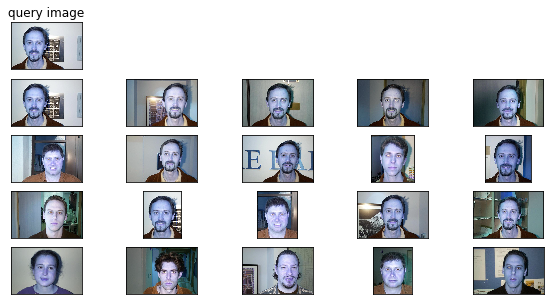

results 1 | time taken : 2.97274494171 | accuracy: 10.0%


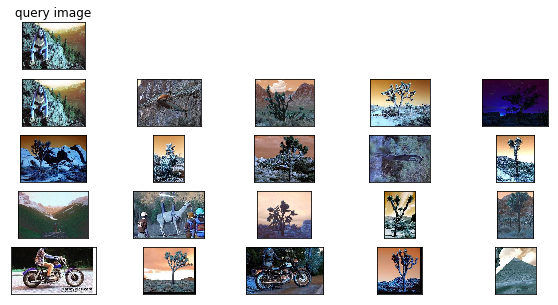

results 2 | time taken : 0.907324075699 | accuracy: 15.0%
percentage reduction:  69.4786 %



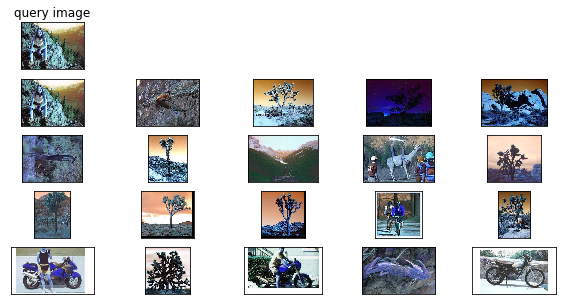

results 1 | time taken : 2.98821401596 | accuracy: 100.0%


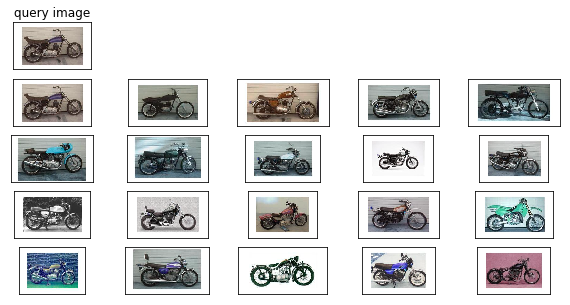

results 2 | time taken : 0.808950901031 | accuracy: 100.0%
percentage reduction:  72.9286 %



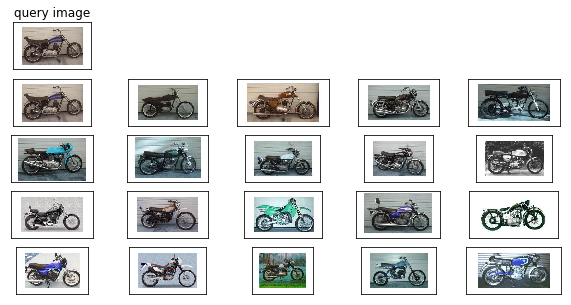

results 1 | time taken : 3.57926011086 | accuracy: 95.0%


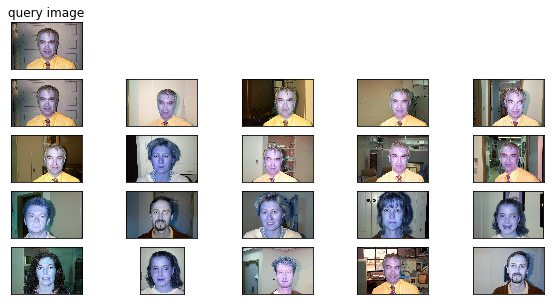

results 2 | time taken : 1.57482504845 | accuracy: 95.0%
percentage reduction:  56.0014 %



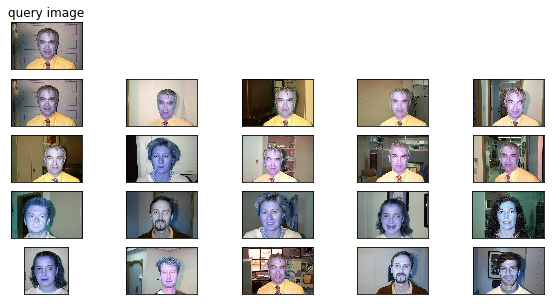

results 1 | time taken : 2.12626504898 | accuracy: 100.0%


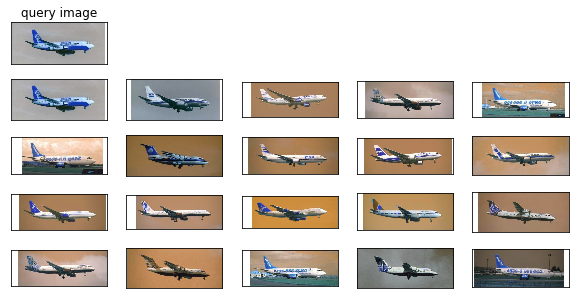

results 2 | time taken : 0.748610019684 | accuracy: 100.0%
percentage reduction:  64.7923 %



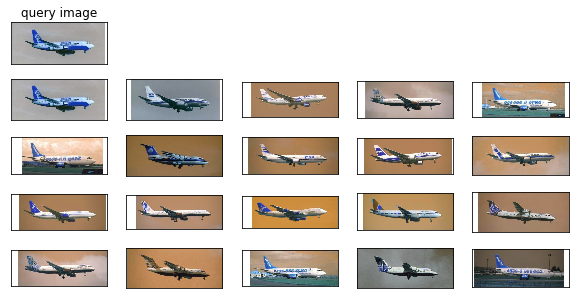

results 1 | time taken : 2.47654390335 | accuracy: 85.0%


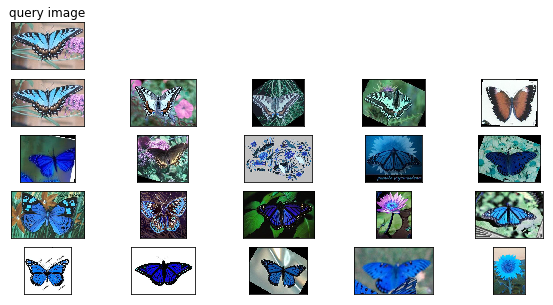

results 2 | time taken : 0.859601020813 | accuracy: 30.0%
percentage reduction:  65.2903 %



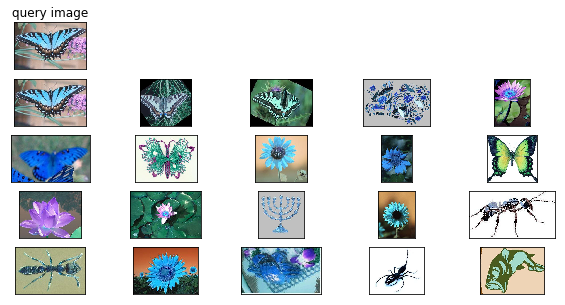

results 1 | time taken : 1.71701312065 | accuracy: 100.0%


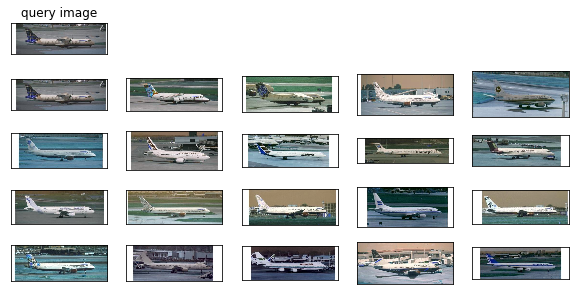

results 2 | time taken : 1.54335999489 | accuracy: 100.0%
percentage reduction:  10.1137 %



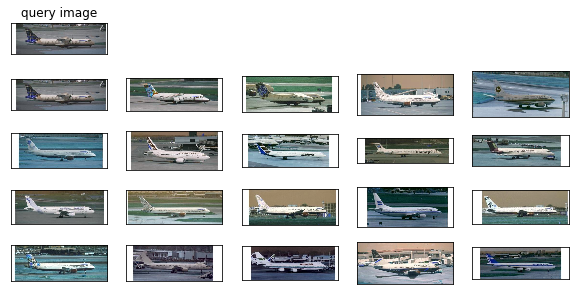

results 1 | time taken : 2.23254704475 | accuracy: 100.0%


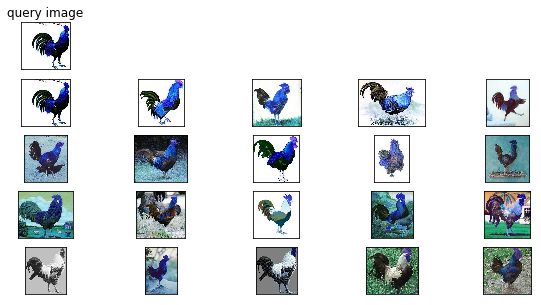

results 2 | time taken : 1.19061303139 | accuracy: 100.0%
percentage reduction:  46.6702 %



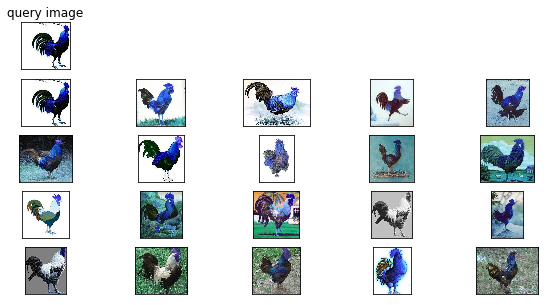

results 1 | time taken : 2.16469192505 | accuracy: 100.0%


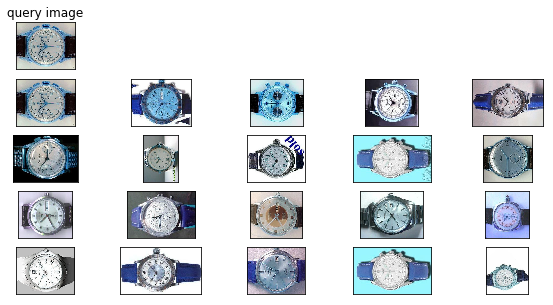

results 2 | time taken : 0.593341827393 | accuracy: 100.0%
percentage reduction:  72.59 %



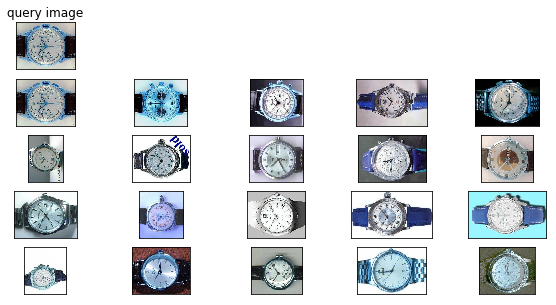

results 1 | time taken : 2.4760890007 | accuracy: 20.0%


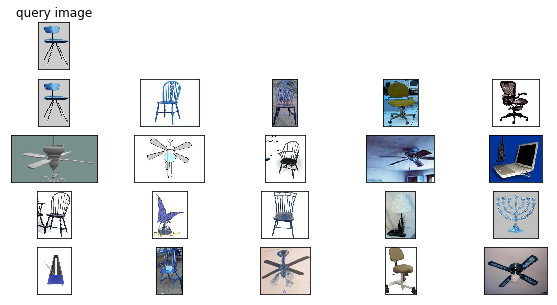

results 2 | time taken : 0.743571043015 | accuracy: 15.0%
percentage reduction:  69.9699 %



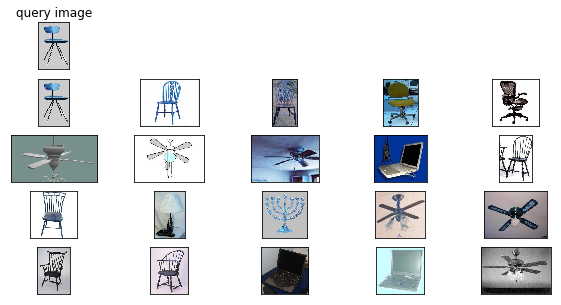

results 1 | time taken : 2.34027314186 | accuracy: 85.0%


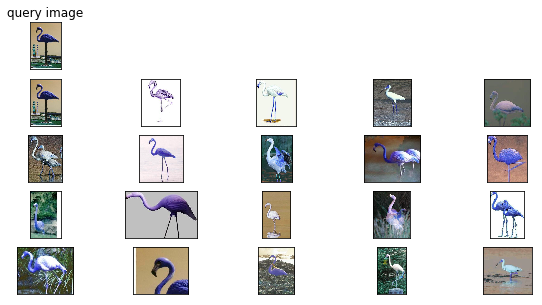

results 2 | time taken : 0.688350915909 | accuracy: 80.0%
percentage reduction:  70.5867 %



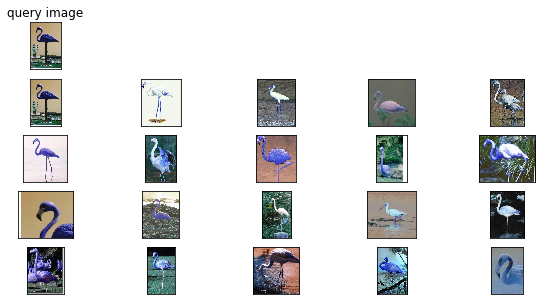

results 1 | time taken : 3.35770106316 | accuracy: 85.0%


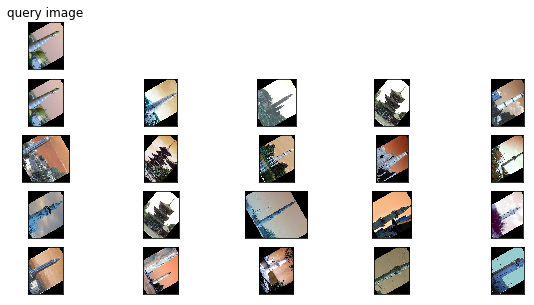

results 2 | time taken : 1.54033899307 | accuracy: 80.0%
percentage reduction:  54.1252 %



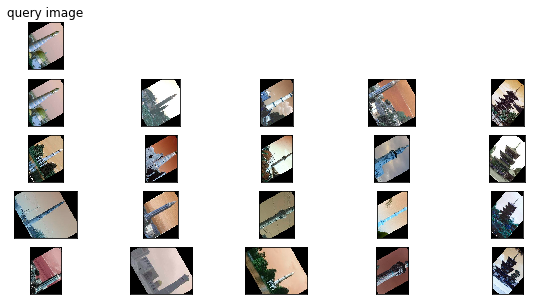

results 1 | time taken : 3.12597799301 | accuracy: 75.0%


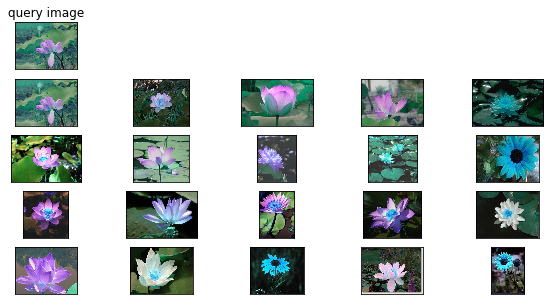

results 2 | time taken : 1.65624189377 | accuracy: 80.0%
percentage reduction:  47.0168 %



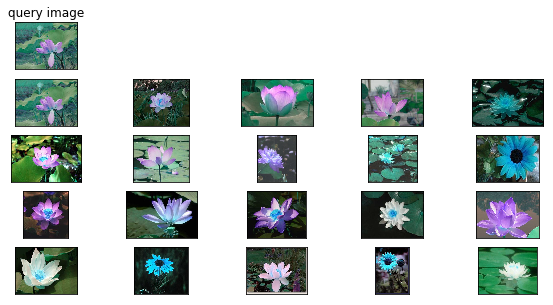

results 1 | time taken : 2.59485006332 | accuracy: 55.0%


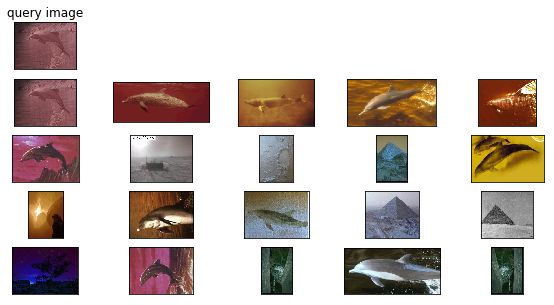

results 2 | time taken : 1.72530508041 | accuracy: 45.0%
percentage reduction:  33.5104 %



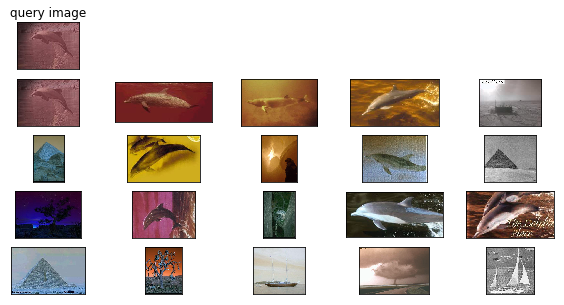

results 1 | time taken : 2.49665093422 | accuracy: 30.0%


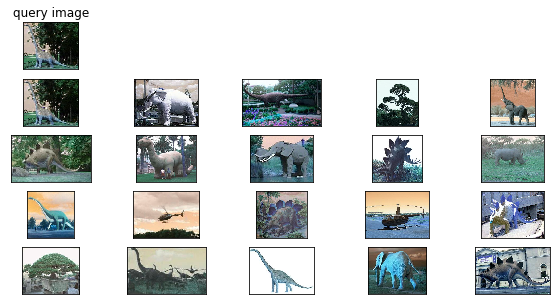

results 2 | time taken : 1.49243998528 | accuracy: 20.0%
percentage reduction:  40.2223 %



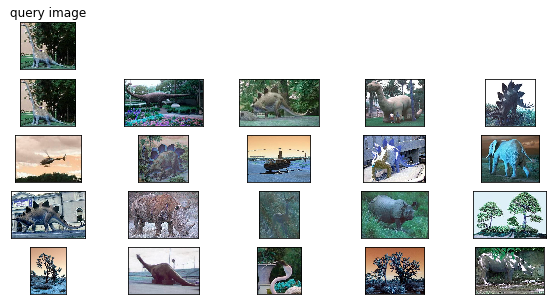

results 1 | time taken : 2.16785979271 | accuracy: 85.0%


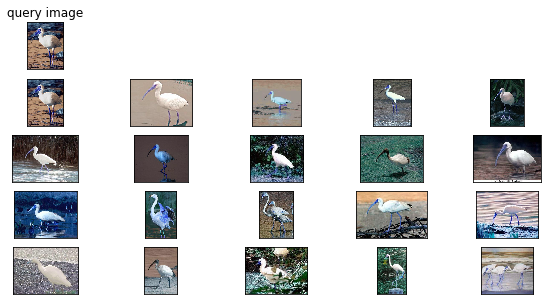

results 2 | time taken : 1.0153670311 | accuracy: 80.0%
percentage reduction:  53.1627 %



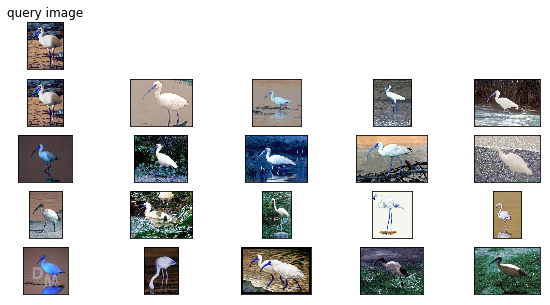

results 1 | time taken : 2.10081481934 | accuracy: 55.0%


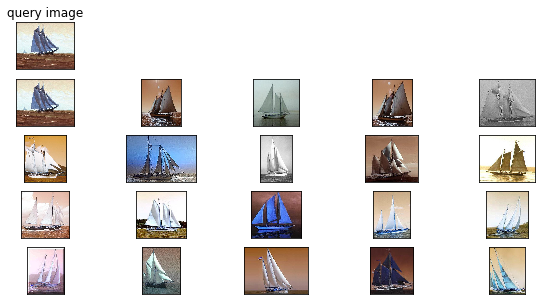

results 2 | time taken : 1.14570212364 | accuracy: 55.0%
percentage reduction:  45.4639 %



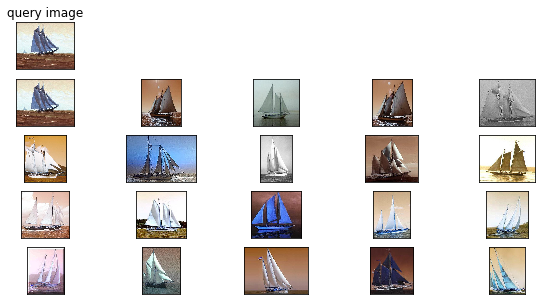

results 1 | time taken : 2.84292006493 | accuracy: 80.0%


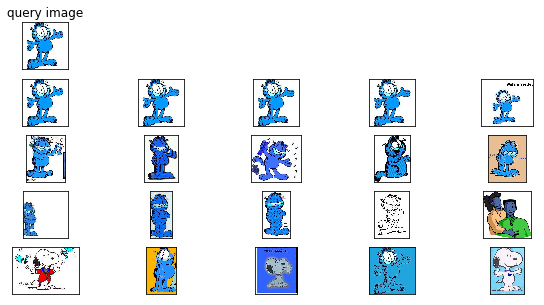

results 2 | time taken : 0.538313150406 | accuracy: 70.0%
percentage reduction:  81.0648 %



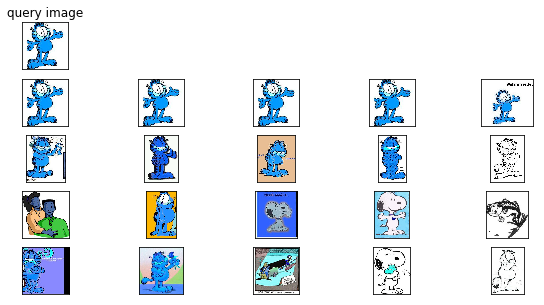

results 1 | time taken : 3.0814678669 | accuracy: 100.0%


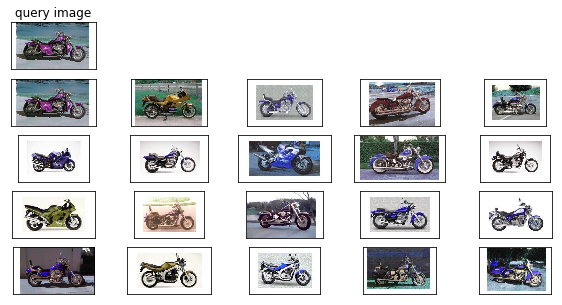

results 2 | time taken : 1.40819406509 | accuracy: 100.0%
percentage reduction:  54.3012 %



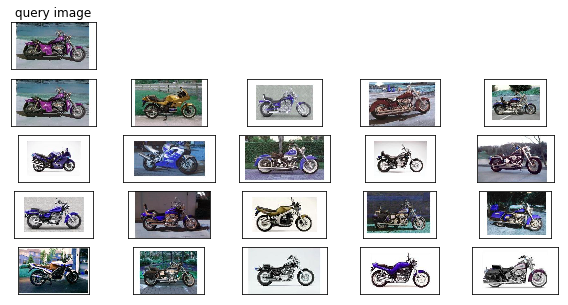

results 1 | time taken : 3.0825688839 | accuracy: 100.0%


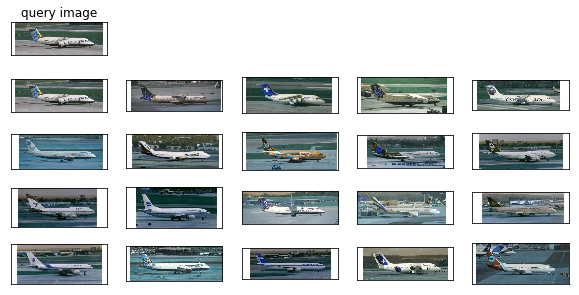

results 2 | time taken : 2.19580698013 | accuracy: 100.0%
percentage reduction:  28.767 %



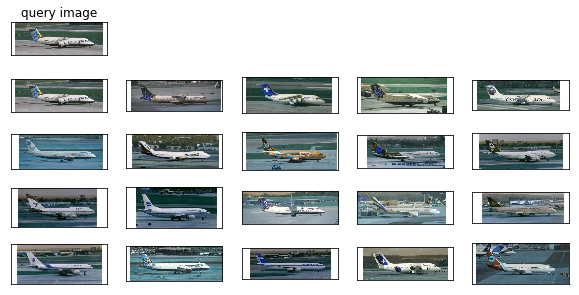

In [74]:
no_queries = 20
no_retrieve = 20
hamming_distance = 2

query_img_idx = [random.randint(0,len(images_path)-1) for i in range(no_queries)]
query_images = [images_path[i] for i in query_img_idx]
                 
searcher = Searcher(index=index_fast, map_path_label=map_path_label, limit=no_retrieve)
time_results1 = []
time_results2 = []

acc_results1 = {}
acc_results2 = {}

acc_results_retrival1 = {}
acc_results_retrival2 = {}


for idx in range(no_retrieve):
    acc_results_retrival1[idx+1] = [0, 0.0]
    acc_results_retrival2[idx+1] = [0, 0.0]

    
for image_path in query_images:
    
    #print "query: %s"% image_path
    query_label = map_path_label[image_path]
    
    if query_label not in acc_results1.keys():
        acc_results1[query_label] = [0, 0.0]
        
    if query_label not in acc_results2.keys():
        acc_results2[query_label] = [0, 0.0]
    
    results1, t1, acc1 = searcher.search(image_path, use_hash = False)
    results2, t2, acc2 = searcher.search(image_path, use_hash = True, hamming_distance= hamming_distance)
    
    acc_score = 0
    for idx, item in enumerate(results1):
        item_label = map_path_label[item[2]]
        if item_label==query_label:
            acc_score += 1
        acc_results_retrival1[idx+1][1] += acc_score/float(idx+1)
        acc_results_retrival1[idx+1][0] += 1
        

    
    acc_score = 0
    for idx, item in enumerate(results2):
        item_label = map_path_label[item[2]]
        if item_label==query_label:
            acc_score += 1
        acc_results_retrival2[idx+1][1] += acc_score/float(idx+1)
        acc_results_retrival2[idx+1][0] += 1
        


    time_results1.append(t1)
    time_results2.append(t2)
    
    acc_results1[query_label][0] += 1
    acc_results2[query_label][0] += 1
    
    acc_results1[query_label][1] += acc1
    acc_results2[query_label][1] += acc2
    
    print "results 1 | time taken : {0} | accuracy: {1}%".format(t1, acc1)
    displayImages(image_path, results1)
    print "results 2 | time taken : {0} | accuracy: {1}%".format(t2, acc2)
    print "percentage reduction: ",round(100 - (t2/t1)*100,4),"%\n"
    displayImages(image_path, results2)

for k in acc_results1.keys():
    acc_results1[k] = acc_results1[k][1]/float(acc_results1[k][0])
    acc_results2[k] = acc_results2[k][1]/float(acc_results2[k][0])

for k in acc_results_retrival1.keys():
    acc_results_retrival1[k] = acc_results_retrival1[k][1]/float(acc_results_retrival1[k][0])
    acc_results_retrival2[k] = acc_results_retrival2[k][1]/float(acc_results_retrival2[k][0])


all_results = [acc_results1, acc_results2, time_results1, time_results2]
# with open('all_results_'+str(no_retrieve), 'wb') as f:
#     pickle.dump(all_results, f)
    
all_results2 = [acc_results_retrival1, acc_results_retrival2]
# with open('all_results2_'+str(no_retrieve), 'wb') as f:
#     pickle.dump(all_results2, f)

In [ ]:
# with open('all_results_'+str(no_retrieve), 'rb') as f:
#     all_results = pickle.load(f)
    
# with open('all_results2_'+str(no_retrieve), 'rb') as f:
#     all_results2 = pickle.load(f)

## Results

In [78]:
acc_results_retrival1, acc_results_retrival2 = all_results2[0], all_results2[1]

In [80]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=acc_results_retrival1.keys()[:50],
    y=acc_results_retrival1.values()[:50],
    name='without hash'
)
trace2 = go.Bar(
    x=acc_results_retrival2.keys()[:50],
    y=acc_results_retrival2.values()[:50],
    name='with hash'
)
data = [trace1, trace2]

layout = go.Layout(
    title='Image Retrieval Precision on cifar dataset',
    xaxis=dict(
        title='# of Top Images Retrieved ',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Precision',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-line')

In [81]:
time_results1, time_results2 = all_results[2], all_results[3]

In [84]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=range(len(time_results1)),
    y=time_results1,
    name='without hash',
   # mode = 'markers'
)
trace2 = go.Scatter(
    x=range(len(time_results2)),
    y=time_results2,
    name='with hash',
    #mode = 'markers'
)
data = [trace1, trace2]

layout = go.Layout(
    title='Retrieval time analysis',
    xaxis=dict(
        title='queries ',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='time(in sec)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time-analysis')

In [85]:
print "Average time reduction {0} sec".format(np.mean(time_results1) - np.mean(time_results2))

Average time reduction 1.44871462584 sec
